# Imports

In [289]:
import urllib.request
import requests
from bs4 import BeautifulSoup
import pandas as pd
from dateutil.parser import parse
import concurrent.futures
import re
from PIL import Image
from time import sleep
from time import time
from random import randint

# Constants

In [268]:
URL = "https://www.imdb.com/search/title/?groups=top_100"

# Exploring data and HTML structure

In [463]:
response = requests.get(URL)
soup = BeautifulSoup(response.text, 'html.parser')

In [270]:
#find_all(tag_name, class)
#find_all() returned a ResultSet object which is a list containing all the 50 divs we are interested in.
movies_containers = soup.find_all('div', 'lister-item mode-advanced')
print(f'Type of movies_containers: {type(movies_containers)}')
print(f'Total items in movies_containers: {len(movies_containers)}')

Type of movies_containers: <class 'bs4.element.ResultSet'>
Total items in movies_containers: 50


We need to extract:
Movie title,
Release year,
Genre,
Rating,
Metascore,
Nr votes,
Poster_url,
Poster

In [272]:
first_movie = movies_containers[0]

In [273]:
first_movie.div #will only select the content of the FIRST div

<div class="lister-top-right">
<div class="ribbonize" data-caller="filmosearch" data-tconst="tt10872600"></div>
</div>

In [274]:
first_movie_content = first_movie.find('div', 'lister-item-content')

In [276]:
first_movie_title = first_movie_content.h3.a.text
first_movie_release_year = first_movie_content.h3.find('span', 'lister-item-year').text
first_movie_genre = re.sub(r'[\t\n ]+', ' ', first_movie_content.p.find('span', 'genre').text).strip()
first_movie_ratings = first_movie_content.find('div', 'ratings-bar').strong.text
first_movie_metascore = re.sub(r'[\t\n ]+', ' ', first_movie_content.find('div', 'ratings-bar').find('span', 'metascore').text).strip()
first_movie_votes = first_movie_content.find('span', {'name':'nv'})['data-value']
first_movie_poster_url = first_movie.find('div', 'lister-item-image').img['loadlate']
first_movie_poster = Image.open(requests.get(first_movie_poster_url, stream=True).raw)

Title | Người Nhện: Không Còn Nhà
Release year | (2021)
Genre | Action, Adventure, Fantasy
Ratings | 8.8
Metascore | 71
Nr votes | 363752
Poster url | https://m.media-amazon.com/images/M/MV5BZWMyYzFjYTYtNTRjYi00OGExLWE2YzgtOGRmYjAxZTU3NzBiXkEyXkFqcGdeQXVyMzQ0MzA0NTM@._V1_UX67_CR0,0,67,98_AL_.jpg


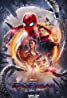

In [277]:
print('Title |', first_movie_title)
print('Release year |', first_movie_release_year)
print('Genre |', first_movie_genre)
print('Ratings |',first_movie_ratings)
print('Metascore |', first_movie_metascore)
print('Nr votes |', first_movie_votes)
print('Poster url |', first_movie_poster_url)
first_movie_poster

# Apply to whole page

In [278]:
def get_movie_title(movie_content):
    try:
        return movie_content.h3.a.text
    except:
        return 'NA'
    
def get_movie_release_year(movie_content):
    try:
        return movie_content.h3.find('span', 'lister-item-year').text
    except:
        return 'NA'

def get_movie_genre(movie_content):
    try:
        return re.sub(r'[\t\n ]+', ' ', movie_content.p.find('span', 'genre').text).strip()
    except:
        return 'NA'

def get_movie_ratings(movie_content):
    try:
        return movie_content.find('div', 'ratings-bar').strong.text
    except:
        return 'NA'

def get_movie_metascore(movie_content):
    try:
        return re.sub(r'[\t\n ]+', ' ', movie_content.find('div', 'ratings-bar').find('span', 'metascore').text).strip()
    except:
        return 'NA'
    
def get_movie_votes(movie_content):
    try:
        return movie_content.find('span', {'name':'nv'})['data-value']
    except:
        return 'NA'

def get_movie_poster_url(movie):
    try:
        return movie.find('div', 'lister-item-image').img['loadlate']
    except:
        return 'NA'


In [279]:
def IMDb_scraping_data(url, preferred_lang='en-US', subs_lang='en', pref_ratio=0.5):
    '''
    Return a dataframe
    url: The URL to the webpage to scrape data
    preferred_lang: specify which language of content to translate into. Default: "en-US"
    subs_lang: if preferred language cannot be translated into then use an alternative language. Default: "en"
    pref_ratio: the degree to which a certain language is preferred
    '''
    res = requests.get(url, headers = {"Accept-Language": f"{preferred_lang},{subs_lang};q={pref_ratio}"})
#     Passing headers as above to prevent your content being translated and keep it original English
#     This will communicate the server something like 
#     I want the linguistic content in American English (en-US). 
#     If en-US is not available, then other types of English (en) would be fine too (but not as much as en-US).”. 
#     The q parameter indicates the degree to which we prefer a certain language. 
#     If not specified, then the values is set to 1 by default, like in the case of en-US. 
    bs = BeautifulSoup(res.text, 'html.parser')
    movies = bs.find_all('div', 'lister-item mode-advanced')
    #Storing data
    title = []
    release_year = []
    genre = []
    ratings = []
    metascore = []
    nr_votes = []
    poster_url = []
    for movie in movies:
        movie_content = movie.find('div', 'lister-item-content')
        movie_title = get_movie_title(movie_content)
        movie_release_year = get_movie_release_year(movie_content)
        movie_genre = get_movie_genre(movie_content)
        movie_ratings = get_movie_ratings(movie_content)
        movie_metascore = get_movie_metascore(movie_content)
        movie_votes = get_movie_votes(movie_content)
        movie_poster_url = get_movie_poster_url(movie)
        #Appending data to their arrays
        title.append(movie_title)
        release_year.append(movie_release_year)
        genre.append(movie_genre)
        ratings.append(movie_ratings)
        metascore.append(movie_metascore)
        nr_votes.append(movie_votes)
        poster_url.append(movie_poster_url)
        
    movie_df = pd.DataFrame(
    {
        'title': title,
        'release_year': release_year,
        'genre': genre,
        'ratings': ratings,
        'metascore': metascore,
        'nr_votes': nr_votes,
        'poster_url': poster_url
    })
    
    return movie_df

In [370]:
url = "https://www.imdb.com/search/title/?groups=top_100"
top_50_movies = IMDb_scraping_data(url)

In [371]:
print('Type:', type(top_50_movies))
print('Total movies:', len(top_50_movies))

Type: <class 'pandas.core.frame.DataFrame'>
Total movies: 50


In [372]:
top_50_movies

,title,release_year,genre,ratings,metascore,nr_votes,poster_url
0,Spider-Man: No Way Home,(2021),"Action, Adventure, Fantasy",8.8,71,363752,https://m.media-amazon.com/images/M/MV5BZWMyYz...
1,The Matrix,(1999),"Action, Sci-Fi",8.7,73,1816000,https://m.media-amazon.com/images/M/MV5BNzQzOT...
2,It's a Wonderful Life,(1946),"Drama, Family, Fantasy",8.6,89,436876,https://m.media-amazon.com/images/M/MV5BZjc4ND...
3,Avengers: Endgame,(2019),"Action, Adventure, Drama",8.4,78,989844,https://m.media-amazon.com/images/M/MV5BMTc5MD...
4,Spider-Man: Into the Spider-Verse,(2018),"Animation, Action, Adventure",8.4,87,458360,https://m.media-amazon.com/images/M/MV5BMjMwND...
5,The Shawshank Redemption,(1994),Drama,9.3,80,2521380,https://m.media-amazon.com/images/M/MV5BMDFkYT...
6,The Lord of the Rings: The Fellowship of the Ring,(2001),"Action, Adventure, Drama",8.8,92,1761828,https://m.media-amazon.com/images/M/MV5BN2EyZj...
7,The Godfather,(1972),"Crime, Drama",9.2,100,1736131,https://m.media-amazon.com/images/M/MV5BM2MyNj...
8,Avengers: Infinity War,(2018),"Action, Adventure, Sci-Fi",8.4,68,964307,https://m.media-amazon.com/images/M/MV5BMjMxNj...
9,The Dark Knight,(2008),"Action, Crime, Drama",9.0,84,2471671,https://m.media-amazon.com/images/M/MV5BMTMxNT...


In [283]:
tmp = IMDb_scraping_data("https://www.imdb.com/search/title/?release_date=2017&sort=num_votes,desc&ref_=adv_nxt")
tmp

,title,release_year,genre,ratings,metascore,nr_votes,poster_url
0,Logan,(2017),"Action, Drama, Sci-Fi",8.1,77,706113,https://m.media-amazon.com/images/M/MV5BYzc5MT...
1,Thor: Ragnarok,(2017),"Action, Adventure, Comedy",7.9,74,670574,https://m.media-amazon.com/images/M/MV5BMjMyND...
2,Guardians of the Galaxy Vol. 2,(2017),"Action, Adventure, Comedy",7.6,67,629120,https://m.media-amazon.com/images/M/MV5BNjM0NT...
3,Wonder Woman,(2017),"Action, Adventure, Fantasy",7.4,76,622874,https://m.media-amazon.com/images/M/MV5BMTYzOD...
4,Dunkirk,(2017),"Action, Drama, History",7.8,94,612100,https://m.media-amazon.com/images/M/MV5BN2YyZj...
5,Star Wars: Episode VIII - The Last Jedi,(2017),"Action, Adventure, Fantasy",6.9,84,599237,https://m.media-amazon.com/images/M/MV5BMjQ1Mz...
6,Spider-Man: Homecoming,(2017),"Action, Adventure, Sci-Fi",7.4,73,594518,https://m.media-amazon.com/images/M/MV5BNTk4OD...
7,Get Out,(I) (2017),"Horror, Mystery, Thriller",7.7,85,544496,https://m.media-amazon.com/images/M/MV5BMjUxMD...
8,Blade Runner 2049,(2017),"Action, Drama, Mystery",8.0,81,522887,https://m.media-amazon.com/images/M/MV5BNzA1Nj...
9,It,(I) (2017),Horror,7.3,69,504183,https://m.media-amazon.com/images/M/MV5BZDVkZm...


# Multiple pages

# Changing URL's parameters

We shall now scrape data from the Top movies in each year (based on number of votes descending)

In [284]:
cur_url = "https://www.imdb.com/search/title/?release_date=2017&sort=num_votes,desc&ref_=adv_nxt"

Our parameters are: release_date=2017 (for year) and start=51 (for page 2)

# Controlling crawl rate

Avoid sending too many requests to a website (otherwise our IP address might get banned)

We’ll control the loop’s rate by using the sleep() function from Python’s time module. sleep() will pause the execution of the loop for a specified amount of seconds.

In [285]:
for i in range(0, 5):
    print(i)
    sleep(randint(1,4))

0
1
2
3
4


In [288]:
from IPython.core.display import clear_output
start_time = time()
nr_requests = 0
for _ in range(5):
# A request would go here
    nr_requests += 1
    sleep(randint(1,3))
    current_time = time()
    elapsed_time = current_time - start_time
    print('Request: {}; Frequency: {} requests/s'.format(nr_requests, nr_requests/elapsed_time))
clear_output(wait = True)

Request: 1; Frequency: 0.496348658121505 requests/s
Request: 2; Frequency: 0.6603281958516793 requests/s
Request: 3; Frequency: 0.49657838799022513 requests/s
Request: 4; Frequency: 0.5670078031260157 requests/s
Request: 5; Frequency: 0.5518983136452112 requests/s


In [290]:
from warnings import warn
warn("Warning Simulation")

<ipython-input-290-931ad44d99f9>:2: UserWarning: Warning Simulation
  warn("Warning Simulation")


In [291]:
start_yr = 2017
end_yr = 2018
NR_PAGES = 2
nr_req = 0
movies_df = pd.DataFrame(columns=['title', 'release_year', 'genre', 'ratings', 'metascore', 'nr_votes', 'poster_url'])
start_time = time()
for y in range(start_yr, end_yr + 1):
    yr = str(y)
    for p in range(NR_PAGES):
        pg = 50 * p + 1
        if pg == 1:
            CUR_URL = f'https://www.imdb.com/search/title/?release_date={yr}&sort=num_votes,desc&ref_=adv_nxt'
        else:
            pg = str(pg)
            CUR_URL = f'https://www.imdb.com/search/title/?release_date={yr}&sort=num_votes,desc&start={pg}&ref_=adv_nxt'
        sleep(randint(8, 15))
        nr_req += 1
        elapsed_time = time() - start_time
        print('Request:{}; Frequency: {} requests/s'.format(nr_req, nr_req/elapsed_time))
        clear_output(wait = True)

        # Throw a warning for non-200 status codes
        if response.status_code != 200:
            warn('Request: {}; Status code: {}'.format(nr_req, response.status_code))

        # Break the loop if the number of requests is greater than expected
        if nr_req > 72:
            warn('Number of requests was greater than expected.')
            break
        movies_df = movies_df.append(IMDb_scraping_data(CUR_URL))

Request:4; Frequency: 0.08300436940615787 requests/s


In [292]:
# movies_df = pd.DataFrame(columns=['title', 'release_year', 'genre', 'ratings', 'metascore', 'nr_votes', 'poster_url'])
# movie_df_1 = IMDb_scraping_data("https://www.imdb.com/search/title/?release_date=2017&sort=num_votes,desc&ref_=adv_nxt")
# movies_df = pd.concat([movies_df, movie_df_1])
# movie_df_2 = IMDb_scraping_data("https://www.imdb.com/search/title/?release_date=2018&sort=num_votes,desc&ref_=adv_nxt")
# movies_df = pd.concat([movies_df, movie_df_2])

In [293]:
movies_df = movies_df.reset_index()

In [294]:
movies_df.tail(50)

,index,title,release_year,genre,ratings,metascore,nr_votes,poster_url
150,0,Tag,(I) (2018),"Action, Comedy",6.5,56,127185,https://m.media-amazon.com/images/M/MV5BNzk4ND...
151,1,The Predator,(2018),"Action, Adventure, Sci-Fi",5.3,48,124603,https://m.media-amazon.com/images/M/MV5BNjZjN2...
152,2,Black Mirror: Bandersnatch,(2018),"Drama, Fantasy, Mystery",7.1,NA,121778,https://m.media-amazon.com/images/M/MV5BMjM5Mz...
153,3,Mortal Engines,(2018),"Action, Adventure, Fantasy",6.1,44,120396,https://m.media-amazon.com/images/M/MV5BNzY1MD...
154,4,Creed II,(2018),"Drama, Sport",7.1,66,117445,https://m.media-amazon.com/images/M/MV5BYmEyNW...
155,5,Skyscraper,(2018),"Action, Adventure, Thriller",5.8,51,117133,https://m.media-amazon.com/images/M/MV5BOGM3Mz...
156,6,Pacific Rim: Uprising,(2018),"Action, Adventure, Sci-Fi",5.6,44,113194,https://m.media-amazon.com/images/M/MV5BMjI3Nz...
157,7,The Commuter,(I) (2018),"Action, Mystery, Thriller",6.3,56,111684,https://m.media-amazon.com/images/M/MV5BMTc0ND...
158,8,Bodyguard,(2018),"Crime, Drama, Thriller",8.1,NA,111023,https://m.media-amazon.com/images/M/MV5BOTQ2Ym...
159,9,"Love, Simon",(2018),"Comedy, Drama, Romance",7.6,72,108474,https://m.media-amazon.com/images/M/MV5BNTMyZD...


# Cleaning scraped data

In [410]:
url = "https://www.imdb.com/search/title/?groups=top_100"
top_100_movies = IMDb_scraping_data(url)
top_100_movies = top_100_movies.append(IMDb_scraping_data("https://www.imdb.com/search/title/?groups=top_100&start=51&ref_=adv_nxt"))

In [411]:
#Exploring the years data
top_100_movies.release_year.unique()

array(['(2021)', '(1999)', '(1946)', '(2019)', '(2018)', '(1994)',
       '(2001)', '(1972)', '(2008)', '(2014)', '(2010)', '(2003)',
       '(1990)', '(1985)', '(2009)', '(2002)', '(2000)', '(1981)',
       '(2012)', '(1995)', '(1993)', '(1977)', '(2006)', '(2020)',
       '(1974)', '(1952)', '(1998)', '(I) (2017)', '(1991)', '(1957)',
       '(1986)', '(1997)', '(1984)', '(1979)', '(1980)', '(1942)',
       '(2004)', '(1966)', '(2011)', '(1983)', '(1975)', '(1968)',
       '(1941)', '(1960)', '(1992)', '(1964)', '(2016)', '(1959)',
       '(1954)', '(1958)', '(1988)', '(1950)', '(1962)', '(1931)',
       '(1940)', '(2007)', '(1936)', '(1963)'], dtype=object)

In [412]:
top_100_movies.loc[:,'release_year'] = top_100_movies.release_year.str[-5:-1].astype(int)

In [414]:
top_100_movies.release_year.head(3)

0    2021
1    1999
2    1946
Name: release_year, dtype: int32

In [413]:
top_100_movies.reset_index(inplace=True)

In [415]:
top_100_movies = top_100_movies.drop(['index'], axis=1)

In [416]:
top_100_movies

,title,release_year,genre,ratings,metascore,nr_votes,poster_url
0,Spider-Man: No Way Home,2021,"Action, Adventure, Fantasy",8.8,71,363752,https://m.media-amazon.com/images/M/MV5BZWMyYz...
1,The Matrix,1999,"Action, Sci-Fi",8.7,73,1816000,https://m.media-amazon.com/images/M/MV5BNzQzOT...
2,It's a Wonderful Life,1946,"Drama, Family, Fantasy",8.6,89,436876,https://m.media-amazon.com/images/M/MV5BZjc4ND...
3,Avengers: Endgame,2019,"Action, Adventure, Drama",8.4,78,989844,https://m.media-amazon.com/images/M/MV5BMTc5MD...
4,Spider-Man: Into the Spider-Verse,2018,"Animation, Action, Adventure",8.4,87,458360,https://m.media-amazon.com/images/M/MV5BMjMwND...
...,...,...,...,...,...,...,...
95,Paths of Glory,1957,"Drama, War",8.4,90,189919,https://m.media-amazon.com/images/M/MV5BNjViMm...
96,Like Stars on Earth,2007,"Drama, Family",8.4,NA,184122,https://m.media-amazon.com/images/M/MV5BMDhjZW...
97,Modern Times,1936,"Comedy, Drama, Family",8.5,96,232452,https://m.media-amazon.com/images/M/MV5BYjJiZj...
98,City Lights,1931,"Comedy, Drama, Romance",8.5,99,178561,https://m.media-amazon.com/images/M/MV5BY2I4Mm...


Drop any films that have no metascore data

In [417]:
top_100_movies = top_100_movies[top_100_movies['metascore'] != 'NA']

In [418]:
top_100_movies.loc[:, 'metascore'] = top_100_movies.metascore.astype(int)
top_100_movies.loc[:, 'ratings'] = top_100_movies.ratings.astype(float)

D:\Adminned\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Add a new column which depicts IMDb ratings in 100-point scale

In [419]:
top_100_movies['100_ratings'] = top_100_movies['ratings'] * 10

<ipython-input-419-4b91ec721725>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_100_movies['100_ratings'] = top_100_movies['ratings'] * 10


Dropping poster_url column because it is not useful

In [420]:
top_100_movies.drop(['poster_url'], axis=1, inplace=True)

D:\Adminned\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [422]:
top_100_movies

,title,release_year,genre,ratings,metascore,nr_votes,100_ratings
0,Spider-Man: No Way Home,2021,"Action, Adventure, Fantasy",8.8,71,363752,88.0
1,The Matrix,1999,"Action, Sci-Fi",8.7,73,1816000,87.0
2,It's a Wonderful Life,1946,"Drama, Family, Fantasy",8.6,89,436876,86.0
3,Avengers: Endgame,2019,"Action, Adventure, Drama",8.4,78,989844,84.0
4,Spider-Man: Into the Spider-Verse,2018,"Animation, Action, Adventure",8.4,87,458360,84.0
...,...,...,...,...,...,...,...
91,Das Boot,1981,"Drama, War",8.3,86,243581,83.0
92,Hara-Kiri,1962,"Action, Drama, Mystery",8.6,85,51259,86.0
95,Paths of Glory,1957,"Drama, War",8.4,90,189919,84.0
97,Modern Times,1936,"Comedy, Drama, Family",8.5,96,232452,85.0


# Saving as csv file

In [423]:
top_100_movies.to_csv('top_100_movies_imbd.csv')

# Visualizing data

In [424]:
import matplotlib.pyplot as plt
%matplotlib inline

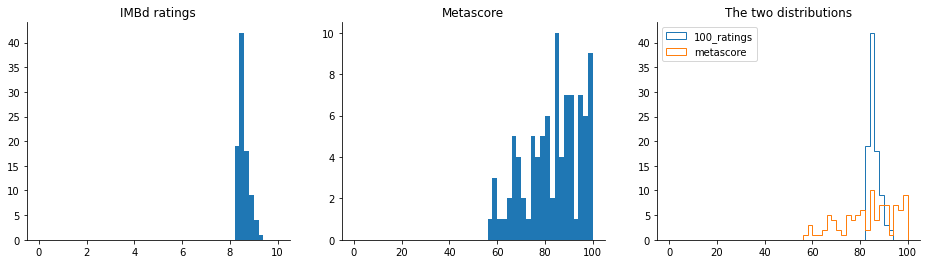

In [456]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16,4))
ax1, ax2, ax3 = fig.axes
ax1.hist(top_100_movies['ratings'], bins = 50, range=(0, 10))
ax1.set_title('IMBd ratings')
ax2.hist(top_100_movies['metascore'], bins = 50, range = (0, 100))
ax2.set_title('Metascore')
ax3.hist(top_100_movies['100_ratings'], bins = 50, range = (0, 100), histtype='step')
ax3.hist(top_100_movies['metascore'], bins = 50, range = (0, 100),histtype='step')
ax3.legend(['100_ratings', 'metascore'], loc='upper left')
ax3.set_title('The two distributions')
for ax in fig.axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.show()

First thing we can be sure of is that all 100 greatest movies, according to IMDb, have a rating between 8 and less than 10.
From that we know, in order for a movie to be considered worthy of being top-tier, it must have a rating score of at least 8.

Metascore criterion is more flexible since the scores given to the movies vary greatly. Some movies might receive a metascore less than 60 but still made it to the top 100 best movies. However, most of the movies are both highly regarded in terms of metascore and imbd ratings.